In [169]:
import datetime as dt
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics, preprocessing
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import model_selection

import warnings
warnings.filterwarnings('ignore')

## 8.1 Data Preparation

#### (a) Load and Prepare Data

In [170]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt

ACC    = pd.read_csv('acceleration.txt', sep = ' ', names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('heartrate.txt', sep = ',', names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('labeled_sleep.txt', sep = ' ', names=['timedelta', 'sleep'])

In [171]:
# Check 'timedelta' max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)

ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()

HeartR_max = HeartR['timedelta'].max()
HeartR_min = HeartR['timedelta'].min()

SleepL_max = SleepL['timedelta'].max()
SleepL_min = SleepL['timedelta'].min()

print(f'ACC start: {ACC_min_date} ACC end: {ACC_max_date}')
print(f'HeartR start: {HeartR_min} HeartR end: {HeartR_max}')
print(f'SleepL start: {SleepL_min} SLeepL end: {SleepL_max}')


ACC start: -124489.16105 ACC end: 17643.046417
HeartR start: -556410.36066 HeartR end: 16980.47229
SleepL start: 0 SLeepL end: 16980


In [172]:
# select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_new = ACC[(ACC['timedelta'] > SleepL_min) & (ACC['timedelta'] < SleepL_max)]
HeartR_new = HeartR[(HeartR['timedelta']> SleepL_min) & HeartR['timedelta']< SleepL_max]
SleepL_new = SleepL[(SleepL['timedelta']> SleepL_min) & SleepL['timedelta']< SleepL_max]

#### (b) Load and Prepare Data (ACC)

In [173]:
# Convert to datetime and round to second,
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))
ACC_new

,timedelta,accX,accY,accZ
98777,0 days 00:00:00,-0.234650,0.905975,0.362747
98778,0 days 00:00:00,-0.231232,0.893265,0.371613
98779,0 days 00:00:00,-0.227814,0.915848,0.369049
98780,0 days 00:00:00,-0.240524,0.919159,0.352890
98781,0 days 00:00:00,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,0 days 04:43:00,-0.442413,-0.527573,0.723450
948797,0 days 04:43:00,-0.441925,-0.527573,0.721985
948798,0 days 04:43:00,-0.441437,-0.526108,0.721985
948799,0 days 04:43:00,-0.443405,-0.525116,0.723434


In [174]:
# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index()
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

In [175]:
ACC = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC

,timedelta,accX,timedelta,accY,timedelta,accZ
0,0 days 00:00:00,-0.243203,0 days 00:00:00,0.895372,0 days 00:00:00,0.367591
1,0 days 00:00:01,-0.240757,0 days 00:00:01,0.873826,0 days 00:00:01,0.415446
2,0 days 00:00:02,-0.244620,0 days 00:00:02,0.883943,0 days 00:00:02,0.387026
3,0 days 00:00:03,-0.248036,0 days 00:00:03,0.902427,0 days 00:00:03,0.347812
4,0 days 00:00:04,-0.241778,0 days 00:00:04,0.912946,0 days 00:00:04,0.321502
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,0 days 04:42:56,-0.525892,0 days 04:42:56,0.722950
16977,0 days 04:42:57,-0.441990,0 days 04:42:57,-0.525476,0 days 04:42:57,0.723410
16978,0 days 04:42:58,-0.441581,0 days 04:42:58,-0.525116,0 days 04:42:58,0.724003
16979,0 days 04:42:59,-0.442283,0 days 04:42:59,-0.525849,0 days 04:42:59,0.723265


In [176]:
ACC = ACC.T.drop_duplicates().T
ACC

,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.24462,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.72295
16977,0 days 04:42:57,-0.44199,-0.525476,0.72341
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


#### (c) Load and Prepare data (Heart rate)

In [177]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'],unit='s').round('1s'))

In [178]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()

#### (d) Load and Preapre Data (Sleep Label)

In [179]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'],unit='s').round('1s'))

In [180]:
# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()

#### (e) Merge Data and Standardized data

In [181]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC, HeartR_new2, on='timedelta')
df = pd.merge_asof(df, SleepL_new2, on='timedelta')

In [182]:
# Fill NA
# Heart rate
# Fillna() # using median()
heart_medain = df.heartrate.median()
df.heartrate.fillna(heart_medain,inplace=True)
# # Sleep Label
# Fillna() # with 0
df.sleep.fillna(0,inplace=True)
# # Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,87.0,-1.0
1,-0.240757,0.873826,0.415446,87.0,-1.0
2,-0.24462,0.883943,0.387026,87.0,-1.0
3,-0.248036,0.902427,0.347812,87.0,-1.0
4,-0.241778,0.912946,0.321502,87.0,-1.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.72295,76.0,0.0
16977,-0.44199,-0.525476,0.72341,76.0,0.0
16978,-0.441581,-0.525116,0.724003,76.0,0.0
16979,-0.442283,-0.525849,0.723265,76.0,0.0


In [183]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = preprocessing.StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns]
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.788122
1,-0.581456,2.995094,0.757746,0.788122
2,-0.591075,3.024668,0.722696,0.788122
3,-0.599581,3.078699,0.674335,0.788122
4,-0.583998,3.109450,0.641889,0.788122
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630659
16977,-1.082531,-1.095348,1.137542,-0.630659
16978,-1.081511,-1.094296,1.138273,-0.630659
16979,-1.083260,-1.096440,1.137363,-0.630659


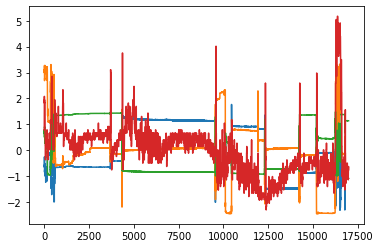

In [184]:
# Visualize signals

lst = [int(i) for i in range(len(df[feature_columns]))]
plt.plot(lst,df_feature.accX)
plt.plot(lst,df_feature.accY)
plt.plot(lst,df_feature.accZ)
plt.plot(lst,df_feature.heartrate)

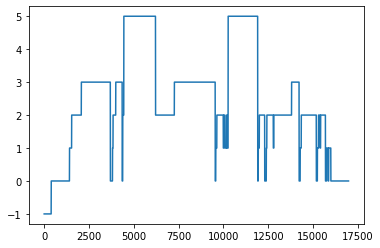

In [185]:
lst = [int(i) for i in range(len(df.heartrate))]
plt.plot(lst,df_label.sleep)

## 8.2 Model Preparation

#### (a) SVM Model Training and Testing

In [186]:
# Train Test Split
x = df_feature
y = df_label
seed = 50
x_train,x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=seed)

In [187]:
# Model Traing Parameter
# Create SVC model
c_val = 100 
gmm = 0.1
d = 2

In [188]:
# Model initialize
svc_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)
svc_poly = SVC(kernel='poly', C=c_val, degree=d)

In [189]:
# Model Training
svc_rbf_pred = svc_rbf.fit(x_train, y_train)
svc_poly = svc_poly.fit(x_train, y_train)

In [190]:
# Model Testing (Predict)
svc_rbf_pred = svc_rbf.predict(x_test)
svc_poly_pred = svc_poly.predict(x_test)

#### (b) SVM Model Trainging and Testing

In [191]:
print('----- Confusion matrix of SVC Rbf -----')
print(confusion_matrix(y_test,svc_rbf_pred))
print('----- Confusion matrix of SVC Poly -----')
print(confusion_matrix(y_test,svc_poly_pred))

----- Confusion matrix of SVC Rbf -----
[[ 117    1    0    0    0    0]
 [   0  551    1  164   27   12]
 [   0   66   48  145    3   10]
 [   0   41    8 1355  113   27]
 [   0    7    0   65 1331    2]
 [   0    0    0  197    0  804]]
----- Confusion matrix of SVC Poly -----
[[ 114    4    0    0    0    0]
 [   4  537  114   55   29   16]
 [   1   20  121  105   13   12]
 [   2   27  124 1161  181   49]
 [   0   17    0  170 1217    1]
 [   0    1    0  158   11  831]]


In [192]:
print('----- Classification matrix of SVC Rbf -----')
print(classification_report(y_test,svc_rbf_pred))
print('----- Classification matrix of SVC Poly -----')
print(classification_report(y_test,svc_poly_pred))

----- Classification matrix of SVC Rbf -----
              precision    recall  f1-score   support

        -1.0       1.00      0.99      1.00       118
         0.0       0.83      0.73      0.78       755
         1.0       0.84      0.18      0.29       272
         2.0       0.70      0.88      0.78      1544
         3.0       0.90      0.95      0.92      1405
         5.0       0.94      0.80      0.87      1001

    accuracy                           0.83      5095
   macro avg       0.87      0.75      0.77      5095
weighted avg       0.84      0.83      0.82      5095

----- Classification matrix of SVC Poly -----
              precision    recall  f1-score   support

        -1.0       0.94      0.97      0.95       118
         0.0       0.89      0.71      0.79       755
         1.0       0.34      0.44      0.38       272
         2.0       0.70      0.75      0.73      1544
         3.0       0.84      0.87      0.85      1405
         5.0       0.91      0.83      0.

## 8.3 Hyperparameter Tuning

In [193]:
# Create Model Parameter Dictionary for SVC
kernel = ['rbf','poly']
C_list = [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]
Gamma_list = [0.01, 0.1, 1.0, 10]
d_list = [2]
params = dict(kernel=kernel, C=C_list, gamma=Gamma_list, degree=d_list)

In [194]:
# Perform GridsearchCV() for each classification model
grid = GridSearchCV(estimator = SVC(), n_jobs=15,verbose = 0, scoring = 'accuracy', cv = 2, param_grid= params)
grid_result = grid.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/uti

In [195]:
# Show best search results
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)

Best params:  {'C': 500.0, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
Best score:  0.9297492848729598


In [196]:
# Show Score for each parameter combination for both model

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
data_zipped = zip(means, stds, params)

for mean, stdev, param in data_zipped:
  print("%f (%f) with: %r" % (mean, stdev, param))
 
data_rbf = [{'means': means[i], 'stds': stds[i], 'params': params[i]} for i in range(len(params)) if params[i]['kernel'] == 'rbf' ]
data_poly = [{'means': means[i], 'stds': stds[i], 'params': params[i]} for i in range(len(params)) if params[i]['kernel'] == 'poly' ]


0.504038 (0.004627) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.299260 (0.000084) with: {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.639828 (0.013545) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.490745 (0.005469) with: {'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.732963 (0.003870) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf'}
0.696197 (0.000757) with: {'C': 0.1, 'degree': 2, 'gamma': 1.0, 'kernel': 'poly'}
0.782854 (0.002776) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'rbf'}
0.778395 (0.007740) with: {'C': 0.1, 'degree': 2, 'gamma': 10, 'kernel': 'poly'}
0.558809 (0.007908) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}
0.387262 (0.000925) with: {'C': 1.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
0.726906 (0.005384) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.648831 (0.001346) with: {'C': 1.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
0.799849 (0.002103) 

<AxesSubplot:>

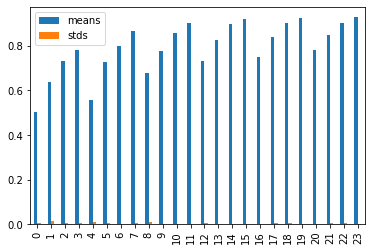

In [197]:
data_rbf = pd.DataFrame(data=data_rbf)
data_rbf.plot.bar()

<AxesSubplot:>

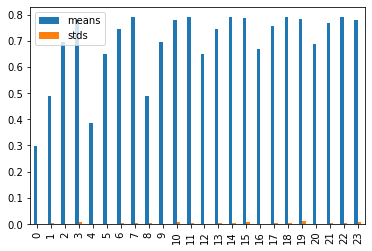

In [198]:
data_poly = pd.DataFrame(data=data_poly)
data_poly.plot.bar()